# Image shortest path

This notebook showes the closest images to a given one.

### Import Variables

In [3]:
%matplotlib inline
import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image
from sklearn.manifold import TSNE
from tqdm import tqdm

### Parse all images in custom folder, saves their color and path into the data array

See: `Save images from Wikidata.ipynb` to create a folder containing images from Wikidata.

In [10]:
data = []
folder = '../assets/wikidata_crop/'

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (10,10))
        image = image.flatten()
        data.append([image, folder + filename])

100%|███████████████████████████████████████| 328/328 [00:00<00:00, 1210.56it/s]


### Training

In [6]:
features, images  = zip(*data)

In [44]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [45]:
len(pca_features), pca_features

(327,
 array([[ 6.14076596e+02,  3.93441392e+02, -8.12275440e+02, ...,
          6.72397610e+00, -9.28521683e-01,  2.69034822e+00],
        [-2.94996491e+02,  1.16187303e+02,  4.10920291e+01, ...,
          1.31518482e+01,  9.43223011e+00,  2.94392242e+00],
        [-1.07701642e+03, -1.63516729e+02,  6.70598921e+02, ...,
          1.07601398e+01, -5.56764417e+00,  3.14506582e+00],
        ...,
        [-4.92506655e+02, -4.28671200e+02, -3.32638571e+01, ...,
          3.06170631e+01, -1.47070769e+01,  2.16717210e+01],
        [ 4.58410896e+02, -4.61045906e+02,  7.43070243e+02, ...,
         -1.96671878e-01,  2.42673504e+00, -3.64867936e+00],
        [-2.89718217e+01,  1.54543331e+02, -1.88378918e+01, ...,
         -1.91765821e+01, -9.35137439e+00, -5.73034043e+00]]))

### Saves the model

In [ ]:
import os
ids = [ os.path.basename(os.path.splitext(x)[0]) for x in images ]

In [ ]:
import os
import json

model_path = "../data/model.json"

data = [{"id":name, "feature":[pd.Series(feature).to_json(orient='values')]} for name, feature in zip(ids, pca_features)]

with open(model_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved model to %s" % model_path)

### Nearest neighbors

In [46]:
num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

Calculate the nearest neighbors and creates a graph from that

In [47]:
kNN = 5

graph = igraph.Graph(directed=True)
graph.add_vertices(len(images))

for i in tqdm(range(len(images))):
    distances = [ distance.cosine(pca_features[i], feat) for feat in pca_features ]
    idx_kNN = sorted(range(len(distances)), key=lambda k: distances[k])[1:kNN+1]
    
    for j in idx_kNN:
        graph.add_edge(i, j, weight=distances[j])
        

100%|████████████████████████████████████████| 327/327 [00:02<00:00, 125.13it/s]


### Test the model

In [48]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = Image.open(images[idx])
        img = img.convert('RGB')
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [52]:
idx1 = int(len(images) * random.random())
idx2 = int(len(images) * random.random())

In [53]:
path = graph.get_shortest_paths(idx1,idx2, output='vpath', weights='weight')[0]

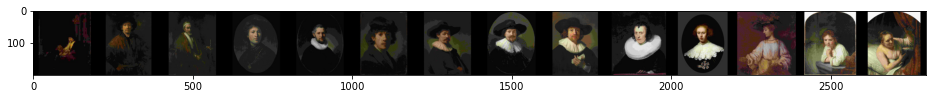

In [54]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

results_image = get_concatenated_images(path, 200)
plt.figure(figsize = (16,12))
imshow(results_image)